In [7]:
import numpy as np
import astropy.units as u
import time
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
import copy
from importlib import reload
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import multiprocessing
from IPython.display import clear_output, display
import subprocess
import glob
from pathlib import Path
import os
from scipy.optimize import curve_fit

import magpyx
from magpyx.utils import ImageStream
import purepyindi
from purepyindi import INDIClient
client0 = purepyindi.INDIClient('localhost', 7624)
client0.start()

from math_module import xp, xcipy, np_array
import utils
import fsm_utils
import cam_utils
import telem
from imshows import imshow1, imshow2, imshow3

cwd = Path(os.getcwd())

wavelength = 633e-9
fl = 450e-3
fsm_pupil_diam = 7.1e-3
as_per_lamD = (wavelength/fsm_pupil_diam*u.radian).to(u.arcsec)
print(as_per_lamD)

lamD_per_pix = 3.45e-6 / (fl * wavelength/fsm_pupil_diam) # lamD per pixel
print(1/lamD_per_pix)

as_per_pix = lamD_per_pix * as_per_lamD
print(as_per_pix)

v_zero = np.array([[0,0,0]]).T
v_bias = np.array([[50,50,50]]).T

18.389524275269295 arcsec
11.62890385793019
1.581363514561072 arcsec


In [47]:
reload(cam_utils)
cam = cam_utils.CAM('campupil')


In [49]:
npsf = 50
cam.set_roi(575, 900, npsf, client0)

In [4]:
cam.set_exptime(0.0001, client0)

INFO:utils:Got semaphore index 1.


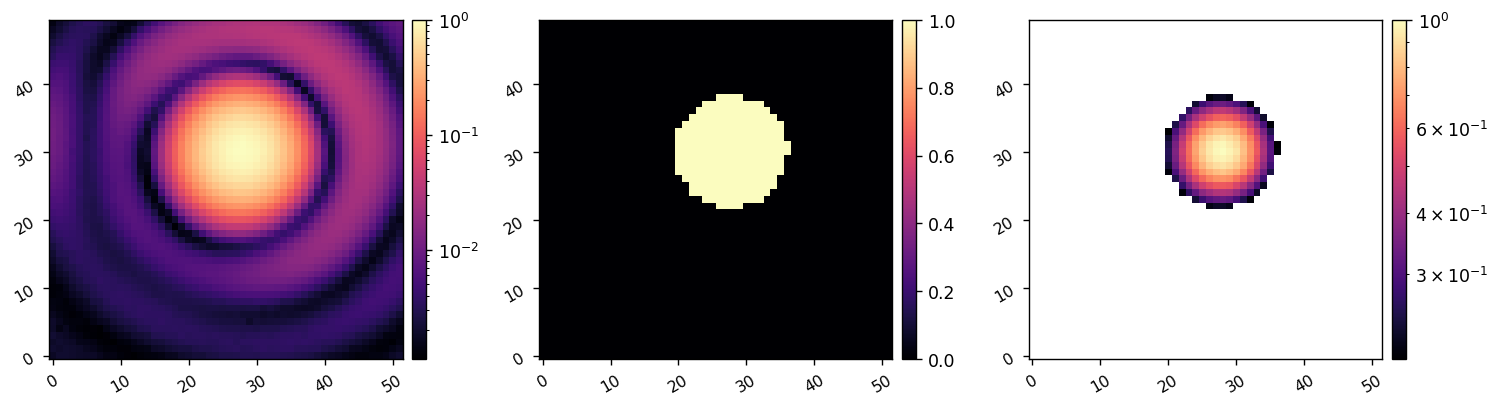

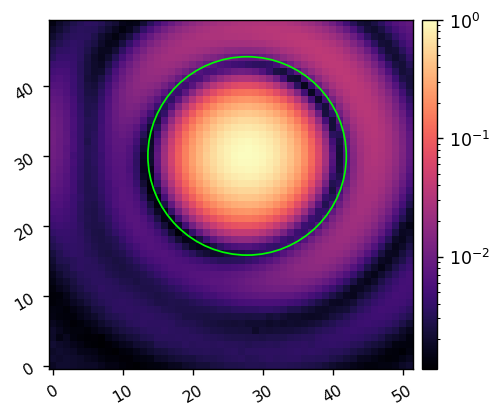

In [50]:
cam.Nframes = 1000
im_bias = cam.snap()

reload(utils)
cen = utils.centroid(im_bias, thresh=0.2, plot=True)
imshow1(im_bias, lognorm=True, patches=[Circle(cen, 1.22/lamD_per_pix, fill=False, color='lime')])


# Setup FSM Interface

In [10]:
fsm_bias_channel = ImageStream('dm00disp00')
fsm_channel = ImageStream('dm00disp10')

In [13]:
fsm_bias_channel.write(v_bias)

In [46]:
fsm_bias_channel.write(v_zero)
fsm_channel.write(v_zero)

# Setup and record the modulation

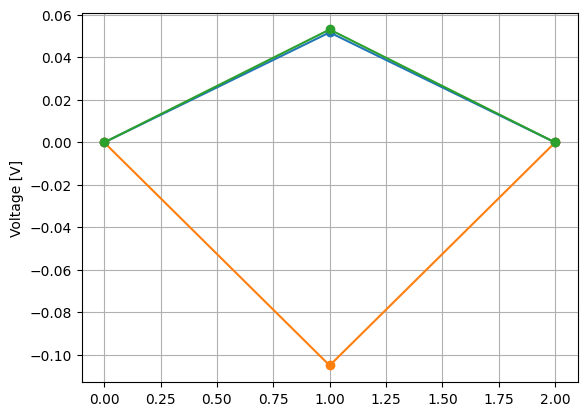

In [14]:
def modulate_fsm(commands, desired_interval, offset=0,):
    print('Modulating FSM ...')
    i = 0
    Nsamps = commands.shape[0]
    total_interval = desired_interval - offset
    while True:
        if i+1==Nsamps: i = 0
        fsm_channel.write(commands[i])
        time.sleep(total_interval)
        i += 1
        
Nsamps = 3
amp = 0.5*u.arcsec

volt_commands = np.zeros((Nsamps, 3, 1))
volt_commands[1] = fsm_utils.get_fsm_volts(tip=amp, tilt=0*u.arcsec)
# volt_commands[i] = fsm_utils.get_fsm_volts(tip=0*u.arcsec, tilt=wave[i])

plt.subplot(111)
# plt.plot(wave)
plt.plot(volt_commands[:,0], '-o')
plt.plot(volt_commands[:,1], '-o')
plt.plot(volt_commands[:,2], '-o')
plt.ylabel('Voltage [V]')
plt.grid()
plt.show()

In [38]:
freq = 300
desired_interval = 1/freq
print(desired_interval, freq)

exp_dir = f'square-{freq:.2f}'
exp_parent_path = Path(f'{cwd}/data/{today}-exps')
exp_path = exp_parent_path / exp_dir
fsm_data_path = exp_path / 'fsm'
cam_data_path = exp_path / 'cam'

telem.make_dir(exp_parent_path)
telem.make_dir(exp_path)
telem.make_dir(fsm_data_path)
telem.make_dir(cam_data_path)

0.0033333333333333335 300
Directory '/home/uasal/Projects/fsm-exps/data/20250214-exps' already exists.
Directory '/home/uasal/Projects/fsm-exps/data/20250214-exps/square-300.00' created successfully.
Directory '/home/uasal/Projects/fsm-exps/data/20250214-exps/square-300.00/fsm' created successfully.
Directory '/home/uasal/Projects/fsm-exps/data/20250214-exps/square-300.00/cam' created successfully.


In [39]:
reload(telem)
telem.delete_files(cam_data_path/'*')
telem.delete_files(fsm_data_path/'*')
telem.delete_files(telem.cam_path/'*')
telem.delete_files(telem.fsm_path/'*')

In [40]:
reload(telem)
mod = multiprocessing.Process(
    name='FSM Modulation', 
    target=modulate_fsm, 
    args=[volt_commands, desired_interval], 
    kwargs={'offset':85e-6},
)

t_meas = 1
delay = 1

cam.Nframes = 100
frame0 = cam.snap()
utils.save_fits(str(cam_data_path/'campupil_0.fits'), frame0)

mod.start()
time.sleep(delay)

telem.toggle_telem_fsm_and_cam(1, client0)
time.sleep(t_meas)
telem.toggle_telem_fsm_and_cam(0, client0)

time.sleep(delay)
mod.terminate()

fsm_channel.write(v_zero)

# Move the files to the defined data directories
telem.move_files(telem.cam_path, cam_data_path)
telem.move_files(telem.fsm_path, fsm_data_path)


Saved data to:  /home/uasal/Projects/fsm-exps/data/20250214-exps/square-300.00/cam/campupil_0.fits
Modulating FSM ...


Moved files from /opt/MagAOX/rawimages/campupil to /home/uasal/Projects/fsm-exps/data/20250214-exps/square-300.00/cam
Moved files from /opt/MagAOX/rawimages/fsm to /home/uasal/Projects/fsm-exps/data/20250214-exps/square-300.00/fsm


In [176]:
mod.terminate()
fsm_channel.write(v_zero)

# Analyze data

In [41]:
reload(telem)
telem.unpack_data(cam_data_path, cam_data_path)
telem.unpack_data(fsm_data_path, fsm_data_path)

In [33]:
freq = 250
desired_interval = 1/freq
print(desired_interval, freq)

exp_dir = f'square-{freq:.2f}'
# exp_parent_path = Path(f'{cwd}/data/20250212-exps')
exp_parent_path = Path(f'{cwd}/data/20250214-exps')
exp_path = exp_parent_path / exp_dir
fsm_data_path = exp_path / 'fsm'
cam_data_path = exp_path / 'cam'

0.004 250


In [42]:
reload(telem)

cam_data_fnames = telem.get_fnames(cam_data_path/'campupil*20250214*.fits')
fsm_data_fnames = telem.get_fnames(fsm_data_path/'dm00disp*20250214*.fits')

fsm_data_fnames[0], cam_data_fnames[0]

('/home/uasal/Projects/fsm-exps/data/20250214-exps/square-300.00/fsm/dm00disp_20250214195405242290143.fits',
 '/home/uasal/Projects/fsm-exps/data/20250214-exps/square-300.00/cam/campupil_20250214195405240554814.fits')

71645.242290143
71645.240554814
0.0017353290022583678
0.0033333333333333335 0.0033253845880566123
300 300.7170970815168


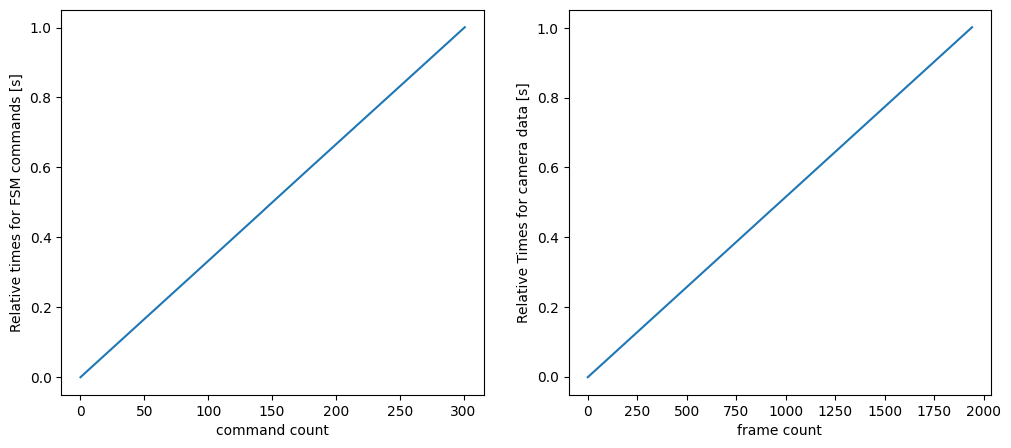

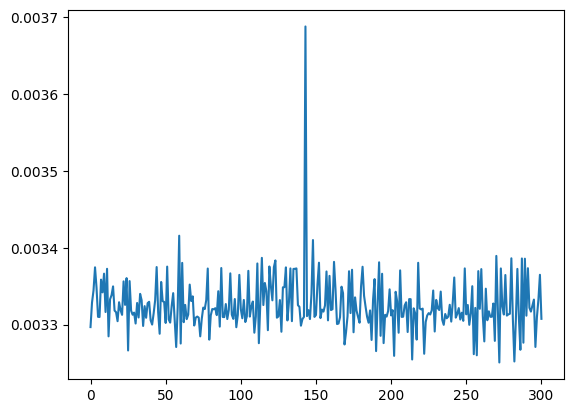

In [43]:
from astropy.io import fits

fsm_commands = []
fsm_times = []
for fname in fsm_data_fnames:
    fsm_commands.append(fits.getdata(fname))
    t_hr = float(fname.split("_")[1][8:10])
    t_min = float(fname.split("_")[1][10:12])
    t_sec = float(fname.split("_")[1][12:-5])/1e9
    fsm_times.append( 3600*t_hr + 60*t_min + t_sec )
fsm_commands = np.array(fsm_commands) 
fsm_times = np.array(fsm_times)
fsm_start = fsm_times[0]
rel_fsm_times = fsm_times - fsm_start

frames = []
cam_times = []
for fname in cam_data_fnames:
    frames.append(fits.getdata(fname))
    t_hr = float(fname.split("_")[1][8:10])
    t_min = float(fname.split("_")[1][10:12])
    t_sec = float(fname.split("_")[1][12:-5])/1e9
    cam_times.append( 3600*t_hr + 60*t_min + t_sec )
frames = np.array(frames) 
cam_times = np.array(cam_times)
cam_start = cam_times[0]
rel_cam_times = cam_times - fsm_start

print(fsm_start) 
print(cam_start)
print(fsm_start - cam_start)

fsm_time_steps = (rel_fsm_times[1:] - rel_fsm_times[:-1])
print(desired_interval, np.mean(fsm_time_steps))
print(freq, 1/np.mean(fsm_time_steps))

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(rel_fsm_times)
plt.ylabel('Relative times for FSM commands [s]')
plt.xlabel('command count')

plt.subplot(122)
plt.plot(rel_cam_times)
plt.ylabel('Relative Times for camera data [s]')
plt.xlabel('frame count')

plt.figure()
plt.plot(fsm_time_steps)

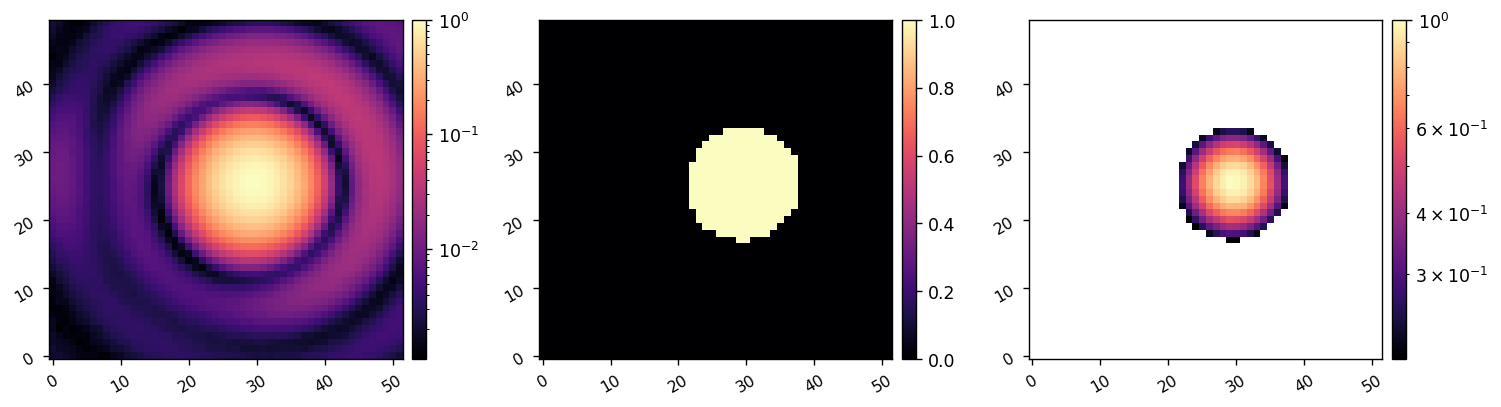

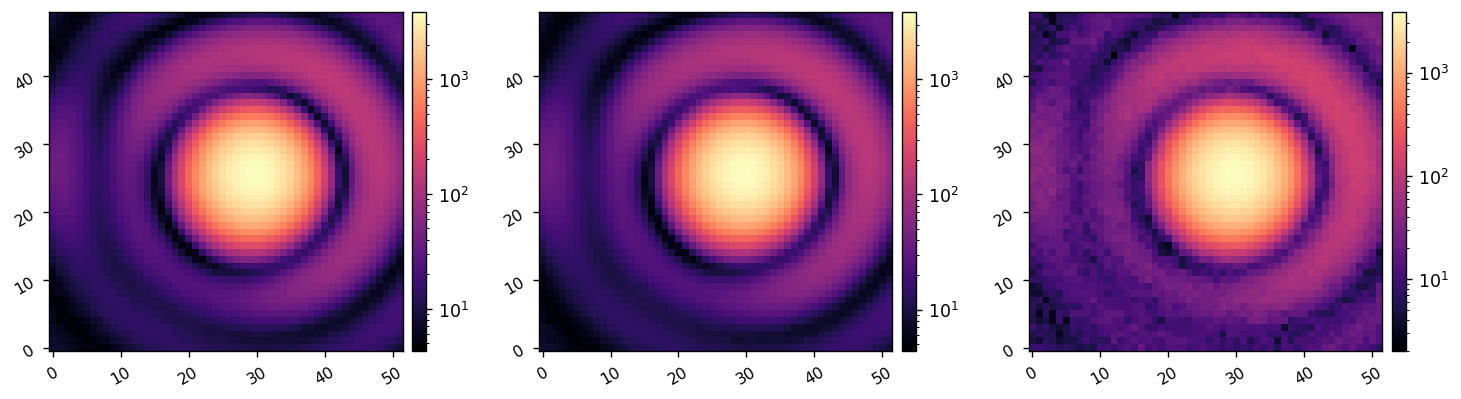

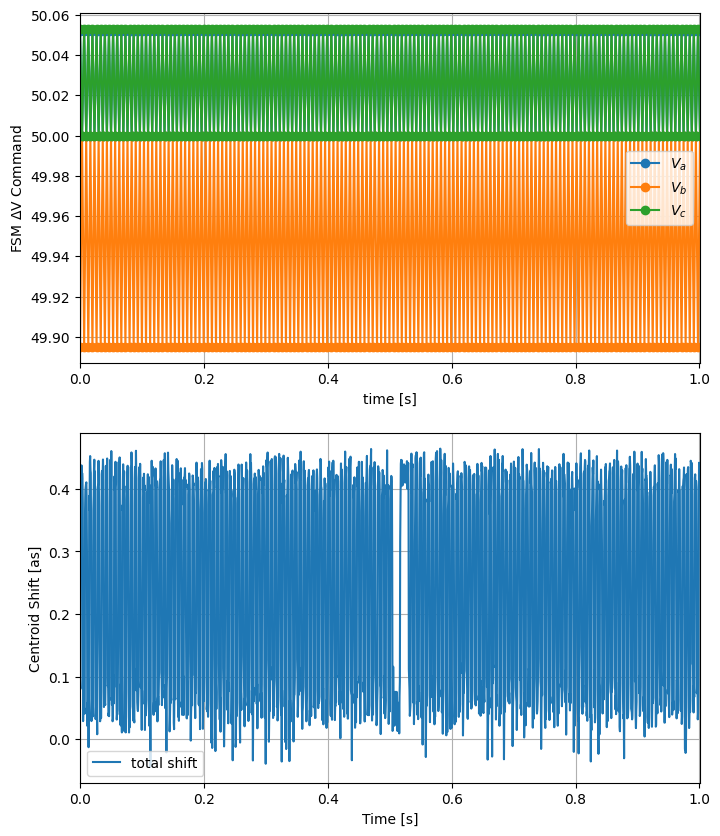

In [44]:
cthresh = 0.2

xmax = rel_fsm_times.max()
# xmax = 0.5

N = len(cam_data_fnames)
frame0 = utils.load_fits(str(cam_data_path/'campupil_0.fits'))
cen_0 = utils.centroid(frame0.astype(float), thresh=cthresh, plot=True)
mean_frame = np.mean(frames, axis=0)
imshow3(frame0, mean_frame, frames[0], lognorm=True)

shift_pix = []
total_shift_pix = []
for i in range(N):
    cen = utils.centroid(frames[i].astype(float), thresh=cthresh, plot=0)
    shift = cen - cen_0
    shift_pix.append(shift)
    if shift[1]>0:
        total_shift_pix.append(np.sqrt(shift[0]**2 + shift[1]**2))
    elif shift[1]<0:
        total_shift_pix.append(-np.sqrt(shift[0]**2 + shift[1]**2))
shift_pix = np.array(shift_pix)
total_shift_pix = np.array(total_shift_pix)

shift_as = shift_pix * as_per_pix
total_shift_as = total_shift_pix * as_per_pix

fig = plt.figure(figsize=(8,10))
plt.subplot(211)
plt.plot(rel_fsm_times, fsm_commands[:,0], '-o', label='$V_a$')
plt.plot(rel_fsm_times, fsm_commands[:,1], '-o', label='$V_b$')
plt.plot(rel_fsm_times, fsm_commands[:,2], '-o', label='$V_c$')
plt.ylabel('FSM $\Delta$V Command')
plt.xlabel('time [s]')
plt.xlim([0, xmax])
# plt.xlim([0, 1])
plt.grid()
plt.legend()

plt.subplot(212)
# plt.plot(rel_cam_times, total_shift_pix, label='total shift')
# plt.plot(rel_cam_times, shift_pix[:,0], label='x-coordinate')
# plt.plot(rel_cam_times, shift_pix[:,1], label='y-coordinate')
# plt.ylabel('Centroid Shift [pixels]')
plt.plot(rel_cam_times, total_shift_as, label='total shift')
# plt.plot(rel_cam_times, shift_as[:,0], label='x-coordinate')
# plt.plot(rel_cam_times, shift_as[:,1], label='y-coordinate')
plt.ylabel('Centroid Shift [as]')
plt.xlabel('Time [s]')
plt.xlim([0, xmax])
# plt.xlim([0, 1])
plt.grid()
plt.legend()

plt.show()

295.0


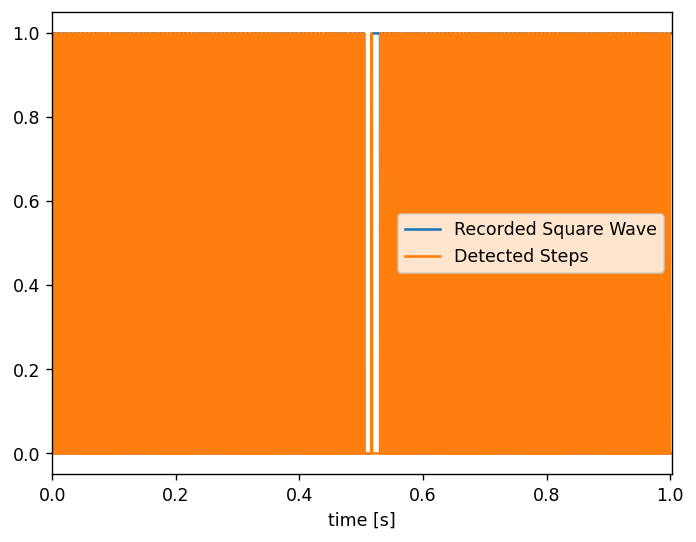

In [45]:
shift_thresh = total_shift_as.max()/2
shift_ud = total_shift_as>shift_thresh

# shift_thresh = total_shift_pix.max()/2
# shift_ud = total_shift_pix>shift_thresh

tmax = rel_cam_times[-1] - rel_cam_times[0]

steps = np.abs(shift_ud[1:].astype(float) - shift_ud[:-1].astype(float))
step_count = np.sum(steps)
print(step_count)

plt.figure(dpi=125)
plt.plot(rel_cam_times, shift_ud, label='Recorded Square Wave')
plt.plot(rel_cam_times[1:], steps, label='Detected Steps')
plt.xlabel('time [s]')
plt.xlim([0,tmax])
plt.legend()
